# TensorFlow Eager

Let's take a closer look at the TensorFlow API as well as TensorFlow's  [eager execution](https://www.tensorflow.org/guide/eager).

The traditional approach of doing computations with TensorFlow requires to build a dataflow graph that can be evaulated in the context of a session (more at [TF guide - Graphs and Sessions](https://www.tensorflow.org/guide/graphs)). However, this way of splitting the computation into a "graph construction phase" and a "execution phase" is unintuitive and especially frustrating for beginners.

In this Colab wel'll leave out graphs and sessions altogether and only use TensorFlow's eager execution mode. Overall, some of its key advantages are:

1.   It's not necessary to build a graph and evaluate it inside sessions before obtaining results.
2.   Reduced boilerplate code.
3. Easier debugging as results and run-time errors are returned immediately.



In [1]:
import json, os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

# As of TensorFlow 1.12, Eager mode still needs to be activated explicitly.
# Expect this to change with TensorFlow 2.0
tf.enable_eager_execution()

# version, GPU?, TPU?
tf.__version__, tf.test.is_gpu_available() and tf.test.is_built_with_cuda(), 'COLAB_TPU_ADDR' in os.environ

('1.12.0', True, False)

In [0]:
## Load data from Drive (Colab only).
data_path = '/content/gdrive/My Drive/amld_data/zoo_img'
## ... or load data from local machine.
# data_path = './amld_data'
## ... or use a prepared dataset from Cloud (Colab only).
# data_path = 'gs://amld-datasets/zoo_img_50k'

In [3]:
# (Copied from ./2_keras.ipynb)
if data_path.startswith('/content/gdrive/'):
  from google.colab import drive
  drive.mount('/content/gdrive')
if data_path.startswith('gs://'):
  from google.colab import auth
  auth.authenticate_user()
  !gsutil ls -lh "$data_path"
else:
  !ls -lh "$data_path"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 2.9G
-rw------- 1 root root   46 Jan 25 23:13 counts.json
-rw------- 1 root root 2.5G Jan 25 23:16 dataframe.pkl
-rw------- 1 root root 5.1M Jan 25 23:12 eval-00000-of-00010
-rw------- 1 root root 5.1M Jan 25 23:12 eval-00001-of-00010
-rw------- 1 root root 5.1M Jan 25 23:12 eval-00002-of-00010
-rw------- 1 root root 5.1M Jan 25 23:12 eval-00003-of-00010
-rw------- 1 root root 5.1M Jan 25 23:12 eval-00004-of-00010
-rw------- 1 root root 5.1M Jan 25 23:12 eval-00005-of-00010
-rw------- 1 root root 5.1M Jan 25 23:12 eval-00006-of-00010
-rw------- 1 root root 5.1M Jan 25 23:12 eval-00007-of-00010
-rw------- 1 root root 5.1M Jan 25 23:13 eval-00008-of-00010
-rw------- 1 root root 5.1M Jan 25 23:12 eval-00009-of-00010
-rw------- 1 root root   89 Jan 25 23:13 labels.txt
-rw------- 1 root root  11M Jan 25 23:12 test-00000-of-00010
-rw------- 1 root root  11M

## Tensors

A Tensor in TF is a generalized format that can describe a scalar, vector, matrix or higher dimensional data (also see
 [TF guide - Tensors](https://www.tensorflow.org/guide/tensors)) and is the most essential data type in TF.  The essential Tensor types include:
*  `tf.constant`
*  `tf.Variable`
*  `tf.SparseTensor`
*  `tf.placeholder` - not supported when using TF with eager execution

The essential Tensor attributes are:

*   Rank - number of dimensions
*   Shape - number of elements in each dimension
* Data type - for example `tf.float32`: **must be the same for every dimension**

Let's look at the different Tensor types.

** tf.constant ** - A basic immutable Tensor

We can define a constant tensor with a dimension of 12x1.

In [4]:
tensor12 = tf.constant([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
print(tensor12, "\nFirst element:\n\t", tensor12[0])

tf.Tensor([ 1  2  3  4  5  6  7  8  9 10 11 12], shape=(12,), dtype=int32) 
First element:
	 tf.Tensor(1, shape=(), dtype=int32)


As can be seen, all components are Tensors themselves, too. This kind of repesentation is useful for example for training data and label where we might want to ensure that no modifications of the source data are possible.

** tf.Variable ** - A mutable Tensor

If we need Tensors that act like variables for instance for tracking a loss we can use `tf.Variable`.

Two options to do so are:

In [5]:
# Define a Variable with a known initial value.
loss = tf.Variable(0.01, dtype=float, name="loss")
loss

<tf.Variable 'loss:0' shape=() dtype=float32, numpy=0.01>

In [6]:
# Define a variable and only later assign a concrete value.
new_var = tf.get_variable("new_var", shape=(), dtype=tf.int32)
new_var

<tf.Variable 'new_var:0' shape=() dtype=int32, numpy=0>

For updates, we can then make use of the `assign` operations TF provides.

Particularly, we can use operations like `.assign`, `.assign_add` and `.assign_sub`.

In [7]:
# YOUR ACTION REQUIRED:
# Assign the value 1531 to `new_var` and then use `.assign_sub` to subtract 194.
new_var.assign(1531) #new_var.
new_var.assign_sub(194) #new_var.
print('Variable:', new_var)
print('Variable value: ', new_var.value())

Variable: <tf.Variable 'new_var:0' shape=() dtype=int32, numpy=1337>
Variable value:  tf.Tensor(1337, shape=(), dtype=int32)


** tf.SparseTensor ** - A sparse representation Tensor

For sparse Tensors, a more efficient representation is `tf.SparseTensor`.

In [8]:
# YOUR ACTION REQUIRED:
# Address the mistakes in the following assignment to define a
# 3x3 matrix with ones on the \ diagonal and zeros everywhere else. 
# Hint: You might want to press <TAB> inside the () to get more information.
sparse_matrix = tf.SparseTensor(dense_shape=[3,3], indices=[[1,1],[2,2],[3,3]], values=[1,1,1])#sparse_matrix = tf.SparseTensor()
sparse_matrix.values

<tf.Tensor: id=36, shape=(3,), dtype=int32, numpy=array([1, 1, 1], dtype=int32)>

Of course, you can also create a diagonal TF matrix in simpler ways by exploring the TF API more.

In [9]:
a=tf.diag([1,1,1])
b=tf.eye(3)
a, b

(<tf.Tensor: id=40, shape=(3, 3), dtype=int32, numpy=
 array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]], dtype=int32)>,
 <tf.Tensor: id=44, shape=(3, 3), dtype=float32, numpy=
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=float32)>)

### Operator overloading & Broadcasting

In general, operator overloading allows to define custom behavior for basic operators like: -, +, / and *. The result might depend on the arguments':
* Order
* Data type
* Content

TensorFlow makes use of operator overloading to simplify the core API as we will see below.

In addition, it makes use of something called Broadcasting.

> "Broadcasting is the process of making arrays with different shapes have compatible shapes for arithmetic operations. The terminology is borrowed from [Numpy broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html)." - see https://www.tensorflow.org/xla/broadcasting

Overall, this allows to succinctly and efficiently operate with tensors of different shapes and types.  

In [10]:
# Broadcasting + operator overloading : Try to write the line below more succintly...
# YOUR ACTION REQUIRED: Simplify the given statement by making use of TF's
# operator overloading and Broadcasting.
tensor12_plus_1 = tensor12 + 1 #tensor12_plus_1 = tensor12 + tf.add(tensor12, tf.ones(shape=tensor12.shape))
tensor12_plus_1

<tf.Tensor: id=48, shape=(12,), dtype=int32, numpy=array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int32)>

TensorFlow accepts Python numbers or Numpy arrays in most places and converts them to tensors on the fly.

In [11]:
# YOUR ACTION REQUIRED:
# Try to replace one or both of the arguments with a
# tf.constant() or with a np.array() and see what happens. Use different shapes.
tf.add(1, 2)

<tf.Tensor: id=52, shape=(), dtype=int32, numpy=3>

In [12]:
# YOUR ACTION REQUIRED:
# Use broadcasting to generate an array like this:
# [[11, 12, 13, ...],
#  [21, 22, 23, ...],
#  [31, 32, 33, ...],
#  ...,
# ]
# (Tip: use tf.range() & tf.reshape() or tf.expand_dims())
#--snip
tf.range(1, 6) + tf.expand_dims(tf.range(1, 6), 1) * 10

<tf.Tensor: id=66, shape=(5, 5), dtype=int32, numpy=
array([[11, 12, 13, 14, 15],
       [21, 22, 23, 24, 25],
       [31, 32, 33, 34, 35],
       [41, 42, 43, 44, 45],
       [51, 52, 53, 54, 55]], dtype=int32)>

When applying an operation to Tensors they must be of the same datatype. In any other case, you might see a ValueError like below.

In [13]:
# YOUR ACTION REQUIRED: Try to change the datatype of one of the tensors to fix the ValueError.
multiplier = tf.constant(1.5)
tf.cast(tensor12, tf.float32) * multiplier #tensor12 * multiplier

<tf.Tensor: id=70, shape=(12,), dtype=float32, numpy=
array([ 1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5,
       18. ], dtype=float32)>

### Handling

Accessing individual elements of a 2D tensor.

In [14]:
# A batch of 3 zero padded 1D tensors.
batch = tf.constant([[1, 2, 3, 0, 0],
                     [2, 4, 6, 8, 0],
                     [3, 6, 0, 0, 0]])
# Note that individual elements have lengths < batch.shape[1]
# but are zero padded.
lengths = tf.constant([3, 4, 2])

# The FIRST elements can be accessed by using Python's
# overloaded bracket indexing OR the related tf.slice():
print('first elements:')
print(batch[0:3, 0:1].numpy())
# Same as above, calling slice operator explicitly.
print(tf.slice(batch, [0, 0], [3, 1]).numpy())

first elements:
[[1]
 [2]
 [3]]
[[1]
 [2]
 [3]]


Accessing the LAST (non-padded) element within every sequence is somewhat more involved.

You need to specify both the indices in the first and the second dimension and then use `tf.gather_nd()`.

In [15]:
# Accessing the last elements is slightly more involved:
indices_0 = list(range(3))
indices_1 = lengths - 1
print('last elements:')
# -> Go check out the documentation of tf.gather_nd() ...
print(tf.gather_nd(batch, tf.transpose([indices_0, indices_1])))

last elements:
tf.Tensor([3 8 6], shape=(3,), dtype=int32)


Below you have an integer tensor and then an expression that is set True for all elements that are odd.

Try to print those elements using the operations `tf.where()` and `tf.gather()`.


In [16]:
numbers = tf.range(1, 11)
odd_condition = tf.logical_not(tf.equal(0, tf.mod(numbers, 2)))

# YOUR ACTION REQUIRED:
# Provide the correct expression for odd_indices and odd_numbers.
# You can use tf.where and tf.gather to this.
odd_indices = tf.where(odd_condition) #odd_indices =
odd_numbers = tf.gather(numbers, odd_indices) #odd_numbers =
odd_numbers.numpy()

array([[1],
       [3],
       [5],
       [7],
       [9]], dtype=int32)

### Shape manipulation

The tensor's underlying data might be on a different device. The tensor object is merely a reference to that data.

** Basic reshaping **

We can reshape a tensor like `tensor12` into a 2x6 format in the following way.

In [17]:
tf.reshape(tensor12, [2, 6])

<tf.Tensor: id=113, shape=(2, 6), dtype=int32, numpy=
array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12]], dtype=int32)>

You can access the underlying data as a **numpy** array. Note the change in notation - tensors don't have methods for shape transformation etc, as opposed to numpy arrays.

In [18]:
tensor12.numpy().reshape([2, 6])

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12]], dtype=int32)

In [19]:
# YOUR ACTION REQUIRED:
# Use `.numpy()` to retrieve the underlying data as a numpy array and then use
# numpy's `.reshape()` to change the shape to a **3x4** matrix.
tensor12.numpy().reshape((3, 4))  #tensor12.

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]], dtype=int32)

** `tf.squeeze()` **

What does `tf.squeeze()` do? Try it out on `tensor12_3` defined below!

In [20]:
tensor12_3 = tf.reshape(tensor12, [3, 2, 2, 1])
tf.squeeze(tensor12_3).shape, tensor12_3.shape #tensor12_3.shape # YOUR ACTION REQUIRED: Apply tf.squeeze() and try to understand what's happening.

(TensorShape([Dimension(3), Dimension(2), Dimension(2)]),
 TensorShape([Dimension(3), Dimension(2), Dimension(2), Dimension(1)]))

## Training a TF model 

**Automatic differentiation with `tf.GradientTape`**

Many optimization problems require the computation of gradients. For this purpose, TF supports automatic differentiation by using a  "tape" to record all operations executed inside the `tf.GradientTape` context.
This log of operations can then be used to compute the gradients with respect to given variables (see [TF Tutorial on Automatic differentiation](https://www.tensorflow.org/tutorials/eager/automatic_differentiation)).

Let's look at a concrete example for using this.

### Machinery to backprop gradients

Let's see how this works in practice. Suppose our goal is to compute the square root of $2$ by utilizing the multiplication operation and the `GradientTape` mechanism.

$x = \pm\sqrt{2} \Leftrightarrow x^2 = 2$

Then we define a "loss" : a numerical quantity that always gets smaller (decreases monotonically) when we get closer to the correct solution:

$loss = (x^2 - 2)^2 \geq 0$

Finally, we compute the gradient of the loss with resepect to x. This gradient will be positive if increasing x increases the loss, and negative if increasing x decreases the loss. This means that we can decrease the loss (=getting closer to the solution) by taking a *small* step against the gradient.

Note that step size ("learning rate") $\eta$ matters : If it is too large, we "overshoot", if it is too small, then we need to take a lot of steps to get to the correct value. This method is called **gradient descent** and is the corner stone of most modern machine learning.

$x:= x - \eta * \triangledown_x loss$

Furthermore, we assume an initial guess of $x = 1.5$.

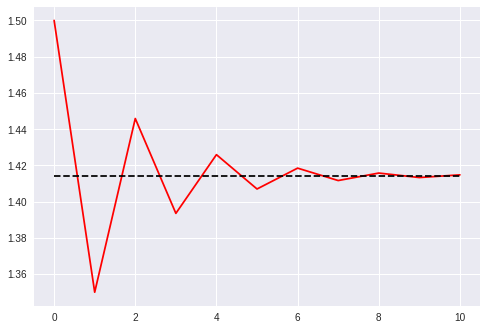

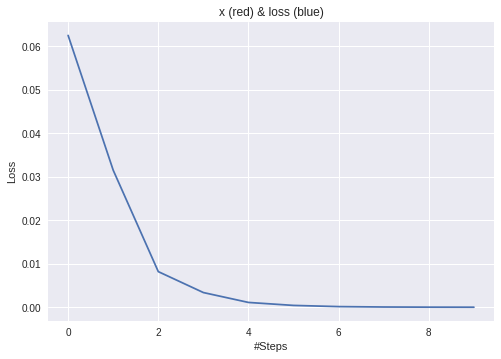

In [21]:
# GradientTape computes gradients with respect to variables. So we need to
# define "x" as a tf.Variable.
# (Note that gradient computation would return None with dtype=int...)
x = tf.Variable(1.5, dtype=float)
f = lambda x: x * x
x_squared_target = 2.0

# Keep values of "x" and "loss" for plotting.
xs = [x.numpy()]
losses = []
for i in range(10):
  with tf.GradientTape() as tape:
    # Compute function value.
    x_squared = f(x)
    # Loss indicates how far off our current guess is.
    # Minimizing loss == finding better value for x.
    loss = (x_squared - x_squared_target) ** 2
  grad = tape.gradient(loss, x)
  x.assign_add(-0.1 * grad)
  xs.append(x.numpy())
  losses.append(loss.numpy())

plt.figure()
plt.plot(xs, 'r-')
sg = xs[-1]/abs(xs[-1])
plt.plot([0, len(xs) - 1], [sg*np.sqrt(x_squared_target)]*2, 'k--')
plt.figure()
plt.plot(losses)
plt.gca().set_title('x (red) & loss (blue)');
plt.xlabel('#Steps')
plt.ylabel('Loss')
None

# YOUR ACTION REQUIRED:
# Try changing the initial value and the learning rate and see what happens...

### Training a linear model

Now let's use gradients to reimplement the linear model from [2_keras.ipynb](https://github.com/tensorflow/workshops/tree/master/extras/amld/notebooks/solutions/2_keras.ipynb)

1. Specifying the training data and labels.
2. Reading and parsing the stored training data into a TF supported format.
3. Training our linear NN model using SGD and the data provided by the previous step. 

**1. Specifying the training data and labels.**

In [22]:
labels = [label.strip() for label in tf.gfile.GFile('{}/labels.txt'.format(data_path))]
counts = json.load(tf.gfile.GFile('{}/counts.json'.format(data_path)))
print("Labels({:d}):\n\t{}".format(len(labels), labels))
print("Counts:\n\t{}".format(counts))

Labels(11):
	['camel', 'crocodile', 'dolphin', 'elephant', 'flamingo', 'giraffe', 'kangaroo', 'lion', 'monkey', 'penguin', 'rhinoceros']
Counts:
	{'eval': 10000, 'test': 20000, 'train': 50000}


**2. Reading and parsing the stored data into a TF supported format.**

In [23]:
# (copied from ./2_keras.ipynb -- see there for comments)

feature_spec = {
    'label': tf.FixedLenFeature(shape=[1], dtype=tf.int64),
    'img_64': tf.FixedLenFeature(shape=[64, 64], dtype=tf.int64),
}

def parse_example(serialized_example):
    features = tf.parse_single_example(serialized_example, feature_spec)
    label = features.pop('label')
    features['img_64'] = tf.cast(features['img_64'], tf.float32) / 255.
    return features['img_64'], tf.one_hot(tf.squeeze(label), len(labels))

batch_size = 100
steps_per_epoch = counts['train'] // batch_size
dataset = tf.data.TFRecordDataset(tf.gfile.Glob('{}/train-*'.format(data_path)))
dataset = dataset.map(parse_example)
dataset = dataset.batch(batch_size).repeat()

# Read a single batch and print tensor dimensions.
for x, y in dataset:
  break
x.shape, y.shape

(TensorShape([Dimension(100), Dimension(64), Dimension(64)]),
 TensorShape([Dimension(100), Dimension(11)]))

** Defining the weights and biases. **

The linear model is defined by the follwoing computation:

$$y = Wx + b$$

With
- $y$ : Probabilities of the output classes (should approach the one-hot encoded labels).
- $x$ : The input (pixel intensities).
- $W$, $b$ : model parameters to be learnt via gradient descent.

In [24]:
# Define the variables with the correct dimensions.
W = tf.Variable(tf.random_normal(shape=(x.shape[1] * x.shape[2], y.shape[1])))
b = tf.Variable(tf.random_normal(shape=(y.shape[1], )))
W.shape, b.shape

(TensorShape([Dimension(4096), Dimension(11)]), TensorShape([Dimension(11)]))

**3. Training our linear NN model using SGD and the data provided by the previous step.**

In [25]:
# YOUR ACTION REQUIRED:
# Adjust the training below to use a decaying learning rate / step size instead
# of using a fixed rate of 0.01.
# (Using a decaying learning rate is often a good idea to make quick progress in
#  the beginning but avoid making too big changes to already tuned parameters.)

learning_rate = lambda epoch: 1 / 10**epoch #

# Record values for loss and accuracy for plotting purposes.
losses = []
accs = []
# Train for two epochs.
epochs = 2
for step, (x, y) in enumerate(dataset):
  if step >= epochs * steps_per_epoch:
    break
  # Compute predictions from input and weights.
  with tf.GradientTape() as tape:
    logits = tf.matmul(tf.reshape(x, (x.shape[0], -1)), W) + b
    loss = tf.losses.softmax_cross_entropy(y, logits)
  losses.append(loss.numpy())
  W_grad, b_grad = tape.gradient(loss, (W, b))

  # Gradient descent.
  W.assign_add(-learning_rate(step / steps_per_epoch) * W_grad) #W.assign_add(-0.01 * W_grad)
  b.assign_add(-learning_rate(step / steps_per_epoch) * b_grad) #b.assign_add(-0.01 * b_grad)

  # Compute accuracy.
  good_preds = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
  acc = tf.reduce_mean(tf.cast(good_preds, tf.float32))
  accs.append(acc.numpy())
  # Prove we didn't freeze...
  if step and step % 100 == 0:
    print('step={:4d} loss={:2.3f} acc={:.3f}'.format(
        step, np.mean(losses[-100:]), np.mean(accs[-100:])))

step= 100 loss=23.091 acc=0.338
step= 200 loss=14.649 acc=0.428
step= 300 loss=12.321 acc=0.458
step= 400 loss=11.852 acc=0.445
step= 500 loss=11.174 acc=0.448
step= 600 loss=9.822 acc=0.486
step= 700 loss=9.776 acc=0.482
step= 800 loss=9.592 acc=0.483
step= 900 loss=10.056 acc=0.467


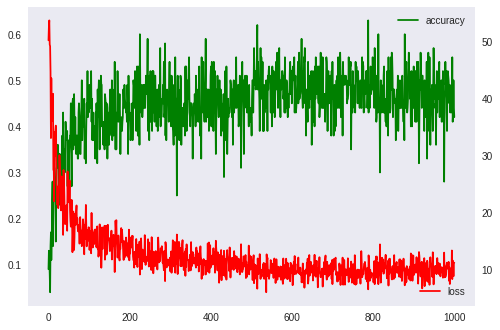

In [26]:
# Plot accuracy (should go up) and loss (should go down).
# Note large variance from one batch to another.
plt.plot(accs, 'g', label='accuracy')
plt.legend(loc='upper right')
plt.grid(False)
plt.twinx().plot(losses, 'r', label='loss')
plt.legend(loc='lower right')
plt.grid(False)

## Keras, revisited

### Models with custom layers

In addition to using Keras in the simplified way as we've seen in `2_keras`,
we can also customize specific layers.

You might want to take a short look at: [TF guide - Keras Custom Layers](https://www.tensorflow.org/guide/keras#custom_layers)

Particulary, this requires us to implement a class inheriting from `tf.keras.layers.Layer` and implementing the methods:

1.   `build`
2.   `call`
3.   `compute_output_shape`
4. (optional) `get_config` and `from_config` for layer serialization support

In [0]:
class MyLinearLayer(tf.keras.layers.Layer):

  def __init__(self, output_dim, **kwargs):
    self.output_dim = output_dim
    super(MyLinearLayer, self).__init__(**kwargs)

  # Define variables using "self.add_weight()" so Keras knows how to update weights.
  def build(self, input_shape):
    shape = tf.TensorShape((input_shape[1], self.output_dim))
    self.W = self.add_weight(name='W',
                             shape=shape,
                             initializer='normal',
                             trainable=True)
    self.b = self.add_weight(name='b',
                             shape=shape[1:],
                             initializer='normal',
                             trainable=True)
    super(MyLinearLayer, self).build(input_shape)

  # Compute outputs from inputs (forward pass).
  def call(self, inputs):
    logits = tf.matmul(inputs, self.W) + self.b
    return tf.nn.softmax(logits)

  # Tell Keras how to verify shape conformity of layer stacking.
  def compute_output_shape(self, input_shape):
    shape = tf.TensorShape(input_shape).as_list()
    shape[-1] = self.output_dim
    return tf.TensorShape(shape)
  
  # Make layer work with model.get_config() and model.from_config().
  def get_config(self):
    base_config = super(MyLinearLayer, self).get_config()
    base_config['output_dim'] = self.output_dim
    return base_config
  
  @classmethod
  def from_config(cls, config):
    return cls(**config)

**Model definition**

We can now define our TF model using `tf.keras.Sequential`.

In [28]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(64, 64,)))
model.add(MyLinearLayer(len(labels)))

model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
my_linear_layer (MyLinearLay (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________


**Training the model**

In [29]:
model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=1)

Epoch 1/1
500/500 [==============================] - 12s 25ms/step - loss: 1.5184 - acc: 0.5114


**Saving and loading a (trained) model**

In [30]:
# Note that the Keras serialized model contains weights and model parameters,
# but not the Python code for creating the layers!
# If you save a model with a custom layer then you need to define the layer and
# provide it to .load_model() as an argument so the model can be instantiated:
model.save('./tmp.h5')
loaded_model = tf.keras.models.load_model('./tmp.h5', dict(MyLinearLayer=MyLinearLayer))

### Training a bidirectional LSTM

Instead of using the images directly, we can also utilize the stroke data in connection with a recurrent neural network.

Particularly, we will train a bidrectional LSTM by going through the following steps:

1. Data preparation
2. Data inspection
3. Model definition
4. Model training

**1. Data preparation**

The stroke data is available inside `TFRecord` files. Let's inspect the features
of one example first.

In [31]:
data_path_stroke = data_path[:-4] + '_stroke'
tf_records_file = tf.gfile.Glob('{}/train-*'.format(data_path_stroke))[0]
print("One TFRecords file:\n\t{}".format(tf_records_file))
for record in tf.io.tf_record_iterator(tf.gfile.Glob('{}/train-*'.format(data_path_stroke))[0]):
  first_example = tf.train.Example.FromString(record)
  break
print("Features in example:\n\t{}".format(' '.join(first_example.features.feature.keys())))

One TFRecords file:
	/content/gdrive/My Drive/amld_data/zoo_stroke/train-00004-of-00010
Features in example:
	countrycode word label stroke_x stroke_y stroke_z stroke_len timestamp key_id recognized


Our recurrent neural network will expect dense tensors with fixed lengths. However, the different examples can have variable stroke lengths.

**Note**: The QuickDraw stroke coordinate "sparse tensors" have a single dimension and do not contain any zeros at all.

Let's define a helper function that:

1.   Limits variable length sparse tensors to a maximum length.
2.   Converts them to dense tensors.

In [0]:
def convert_sparse(sparse, max_len):
  """Converts batched sparse tensor to dense tensor with specified size.

  Args:
    sparse: tf.SparseTensor instance of shape=[n].
    max_len: Truncates / zero-pads the dense tensor the specified max_len.
  """
  # Convert to dense tensor.
  dense = tf.sparse.to_dense(sparse)
  # Discard values above max_len.
  dense = dense[:max_len]
  # Zero-pad if length < max_len.
  dense = tf.pad(dense, [[0, max_len - tf.shape(dense)[0]]])
  return dense

Let's look at an example to see how `convert_sparse()` works.

We will use `stroke_x` as an example `tf.SparseTensor` with the X-coordinates `[1,2,3,4,5]`.

In [33]:
stroke_x = tf.SparseTensor(
    indices=[[0], [1], [2], [3], [4]],
    values=[1, 2, 3, 4, 5],
    dense_shape=[5])
# Extract both shorter and longer dense tensors.
dense_short = convert_sparse(stroke_x, max_len=3)
dense_long = convert_sparse(stroke_x, max_len=10)
print("Dense short (max_len=3):\n\t{}".format(dense_short.numpy()))
print("Dense long (max_len=10):\n\t{}".format(dense_long.numpy()))

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Dense short (max_len=3):
	[1 2 3]
Dense long (max_len=10):
	[1 2 3 4 5 0 0 0 0 0]


In [34]:
labels_stroke = [label.strip() for label in tf.gfile.GFile('{}/labels.txt'.format(data_path_stroke))]
counts_stroke = json.load(tf.gfile.GFile('{}/counts.json'.format(data_path_stroke)))
print("Labels({:d}):\n\t{}".format(len(labels_stroke), labels_stroke))
print("Counts:\n\t{}".format(counts_stroke))

Labels(11):
	['camel', 'crocodile', 'dolphin', 'elephant', 'flamingo', 'giraffe', 'kangaroo', 'lion', 'monkey', 'penguin', 'rhinoceros']
Counts:
	{'eval': 10000, 'test': 20000, 'train': 50000}


In [0]:
# Maximum number of points in concatenated strokes (known beforehand).
MAX_LEN = 256

# Because every drawing has a different number of points, we use "VarLenFeature"
# and not "FixedLenFeature" for the stroke data. This will create a
# "SparseTensor".
feature_spec_stroke = {
    'stroke_x': tf.VarLenFeature(dtype=tf.float32),
    'stroke_y': tf.VarLenFeature(dtype=tf.float32),
    'stroke_z': tf.VarLenFeature(dtype=tf.float32),
    'stroke_len': tf.FixedLenFeature([], tf.int64),
    'label': tf.FixedLenFeature([], tf.int64),
}

def parse_example_stroke(serialized_example):
  """Parses a given tf.Example and creates a dense (limited) length tensor.

  Args:
    serialized_example: tf.Example to parse.
  """
  features = tf.parse_single_example(serialized_example, feature_spec_stroke)
  label = features.pop('label')

  # We create a 'stroke' tensor with shape [3, MAX_LEN] where the first
  # dimension indicates whether the values are X, Y, or Z coordinates.
  stroke = tf.stack([
      convert_sparse(features['stroke_x'], max_len=MAX_LEN),
      convert_sparse(features['stroke_y'], max_len=MAX_LEN),
      convert_sparse(features['stroke_z'], max_len=MAX_LEN),
  ])
  stroke = tf.transpose(stroke, perm=[1, 0])

  # Also truncate the "stroke_len" to MAX_LEN if needed.
  stroke_len = tf.minimum(tf.cast(MAX_LEN, tf.int64), features['stroke_len'])

  return stroke, tf.one_hot(label, depth=len(labels_stroke))

def make_ds_stroke(files_pattern, batch_size=100):
  """Converts all data within multiple TFRecord files into a
     dense (limited) length tensor format, shuffles them and creates batches.

  Args:
    files_pattern: Path with the format `[...]/train-*`.
    batch_size: Size to use for generating batches. 
  """
  dataset = tf.data.TFRecordDataset(tf.gfile.Glob(files_pattern))
  dataset = dataset.map(parse_example_stroke).batch(batch_size)
  dataset = dataset.shuffle(buffer_size=5*batch_size).repeat()
  return dataset

In [0]:
batch_size = 100
steps_per_epoch = counts_stroke['train'] // batch_size
ds_stroke = make_ds_stroke('{}/train-*'.format(data_path_stroke), batch_size)
ds_stroke_test = make_ds_stroke('{}/test-*'.format(data_path_stroke), batch_size)

**2. Data inspection**

We can now use Matplotlib to visualize the stroke data.

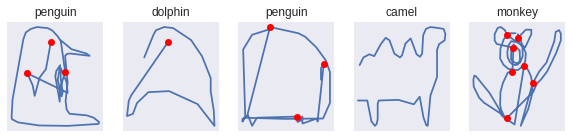

In [37]:
# From ./1_data.ipynb

from matplotlib import pyplot as plt

def show_stroke_img(stroke, label, ax=None):
  """Plots stroke data.

  Args:
    stroke: Array of shape=[3, n] where the second dimension
        is time and the first dimension indicates X/Y coordinates
        and Z-dimension that is set to 1 when a stroke ends and
        0 otherwise (the array actually represents an array of
        concatenated strokes and the Z-dimension is needed to tell
        the individual strokes apart).
  """
  ax = ax if ax else plt.gca()
  xy = stroke[:2, :].cumsum(axis=1)
  ax.plot(xy[0, :], -xy[1, :])
  # Plot all the strokes, including connecting line between strokes.
  pxy = xy[:, stroke[2] != 0]
  # Red dots mark end of individual strokes.
  ax.plot(pxy[0], -pxy[1], 'ro')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(label)

# Load a single batch of images:
for x, y in ds_stroke:
  break

# Plot some images
plt.figure(figsize=(10, 2))
for i in range(5):
  ax = plt.subplot(1, 5, i+1)
  show_stroke_img(x[i].numpy().T, labels_stroke[y[i].numpy().argmax()], ax)

**3. Model definition**

While defining a linear model using basic TensorFlow operations was quite easy, defining a bidirectional LSTM would be a nightmare!

Luckily Keras provides us with good implementations of many common network components and putting these together requires only a few lines of code:

In [38]:
lstm_model = tf.keras.Sequential()

if tf.test.is_gpu_available():
  # CuDNNLSTM doesn't support masking.
  lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(units=256), input_shape=(MAX_LEN, 3)))
else:
  # Masking means that we don't do computations on all the "0" used for padding
  # of sequences shorter than MAX_LEN.
  # While masking is not strictly needed it makes learning a lot faster.
  lstm_model.add(tf.keras.layers.Masking(mask_value=0., input_shape=(MAX_LEN, 3)))
  lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256), input_shape=(MAX_LEN, 3)))

lstm_model.add(tf.keras.layers.Dense(len(labels_stroke), activation='softmax'))

lstm_model.compile(
    optimizer=tf.train.AdamOptimizer(0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.categorical_accuracy])

lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 512)               534528    
_________________________________________________________________
dense (Dense)                (None, 11)                5643      
Total params: 540,171
Trainable params: 540,171
Non-trainable params: 0
_________________________________________________________________


**4. Training the model**


In [39]:
# This is a pretty heavy model. If you train on CPU you probably want to reduce
# the number of steps...
lstm_model.fit(ds_stroke, steps_per_epoch=steps_per_epoch, epochs=1)
lstm_model.evaluate(ds_stroke_test, steps=10)

Epoch 1/1
10/10 [==============================] - 8s 751ms/step


[2.4450064182281492, 0.0949999988079071, 0.0949999988079071]

# ----- Optional part -----

## TensorBoard

TensorBoard is a great tool to observe variables during training (especially useful)

In [0]:
# You can also run this section multiple times specifying different values for
# "tensorboard_path" -- TensorBoard allows you to compare the different runs.
tensorboard_path = './tensorboard/lstm1'
!rm -rf $tensorboard_path
os.makedirs(tensorboard_path, exist_ok=True)

In [0]:
# This callback will make Keras record loss and metrics.
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path),
]

In [42]:
# "strokes" has shape [?, MAX_LEN, 3] and was converted from a sparse tensor.
# Unless the original variable length tensor had a length >= MAX_LEN, the tensor
# will be filled with zeroes at indices [?, stroke_length:, :] - this function
# returns the actual stroke lengths for a batch of padded strokes.
def get_stroke_lengths(strokes):
  batch_size, max_length = strokes.shape.as_list()[:2]
  nonzero = tf.greater(tf.reduce_sum(tf.cast(tf.greater(strokes, 0), tf.float32), axis=2), 0)
  return max_length - tf.argmax(tf.cast(nonzero, tf.float32)[:,::-1], axis=1)

# Illustrate the function's return value with an example:
get_stroke_lengths(tf.constant([[[0.1], [0.2], [0], [0.1], [0], [0]]]))

<tf.Tensor: id=552648, shape=(1,), dtype=int64, numpy=array([4])>

In [0]:
# Under the hood, Keras will initialize a "summary writer" and then use
# tf.contrib.summary.scalar() to record loss/metrics during training.
# The following method will record the stroke_len. For these instrutions to be
# called with the data of every processed batch, we wrap it into a "Lambda"
# layer (a Keras layer wrapping a Python function that has no weights).
# Note that usually we would use Lambda layers to perform some computation on
# the input. In this case we "pass through" the input, but inspect it and record
# summaries.

summary_writer = tf.contrib.summary.create_file_writer(
    tensorboard_path, flush_millis=1000)

def record_stroke_length(strokes):
  # Manually increase the step counter. This will serve as the "x axis".
  tf.train.get_or_create_global_step().assign_add(1)
  stroke_lengths = get_stroke_lengths(strokes)
  with summary_writer.as_default():
    with tf.contrib.summary.always_record_summaries():
      # Record the average length at every step:
      tf.contrib.summary.scalar('average_stroke_lengths', tf.reduce_mean(stroke_lengths))
    with tf.contrib.summary.record_summaries_every_n_global_steps(10):
      # Record the length distribution every 10 steps. Check out the
      # visualizations in TensorBoard's "histogram" and "distribution" tabs!
      tf.contrib.summary.histogram('stroke_lengths', stroke_lengths)
  return strokes

In [0]:
# Code copied from section "Training a bidirectional LSTM", but with an
# additional Lambda layer for the recording fo the stroke lengths:

lstm_model = tf.keras.Sequential()

lstm_model.add(tf.keras.layers.Lambda(record_stroke_length, input_shape=(MAX_LEN, 3)))

if tf.test.is_gpu_available():
  # CuDNNLSTM doesn't support masking.
  lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(units=256)))
else:
  # Masking means that we don't do computations on all the "0" used for padding
  # of sequences shorter than MAX_LEN.
  # While masking is not strictly needed it makes learning a lot faster.
  lstm_model.add(tf.keras.layers.Masking(mask_value=0., input_shape=(MAX_LEN, 3)))
  lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256)))

lstm_model.add(tf.keras.layers.Dense(len(labels_stroke), activation='softmax'))

lstm_model.compile(
    optimizer=tf.train.AdamOptimizer(0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.categorical_accuracy])

# Reset step count used for recording of summaries (see above cell).
tf.train.get_or_create_global_step().assign(0);

In [45]:
# Forwarding of TensorBoard's 6006 port using https://ngrok.com

# Download & unzip ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip
!ls -lh ./ngrok
!pkill tensorboard; pkill ngrok

# Start TensorBoard
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(os.path.dirname(tensorboard_path))
)
# Forward port.
get_ipython().system_raw('./ngrok http 6006 &')
# Give some time to start up.
!sleep 1
# Output external address (ngrok's web interface listens at 4004).
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-01-25 23:23:25--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.22.236.254, 52.86.186.182, 52.207.111.186, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.22.236.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.9’

ngrok-stable-linux- 100%[===================>]   5.11M  9.71MB/s    in 0.5s    

2019-01-25 23:23:25 (9.71 MB/s) - ‘ngrok-stable-linux-amd64.zip.9’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
-rwxr-xr-x 1 root root 16M Jul 15  2017 ./ngrok
http://86dd011d.ngrok.io


In [46]:
# Frist open TensorBoard in a seaprate tab by clicking on above link ^^.

# Then let's create a new model and train it again.
# Check out TensorBoard during training (click on the "refresh" button to see
# new data).
history = lstm_model.fit(ds_stroke, steps_per_epoch=steps_per_epoch, epochs=1, callbacks=callbacks)

Epoch 1/1
500/500 [==============================] - 98s 196ms/step - loss: 2.4106 - acc: 0.1301 - categorical_accuracy: 0.1301


In [47]:
# Summaries are stored as "events.out.tfevents.*" files.
# BTW you can also parse these data programatically using
# tf.train.summary_iterator()
!find $tensorboard_path

./tensorboard/lstm1
./tensorboard/lstm1/events.out.tfevents.1548458604.d711d7f512b1.v2


In [0]:
# YOUR ACTION REQUIRED:
# Re-run this entire section, but provide a different subdirectory name
# for "tensorboard_path" (e.g. "lstm2" instead of the original "lstm1").
# Use TensorBoard to compare the different runs. This exercise is especially
# interesting if you also change some model parameters (try changing the cell
# size or adding some Dense layers at the end, for example).

## More shape manipulation

So you think shapes are easy, right? Well... Then here we go with a real-world shape challenge!

(You probably won't have time to finish this challenge during the workshop; come back to this later and don't feel bad about consulting the solution...)

 Imagine you have a recurrent neural network that outputs a "sequence"
 tensor with dimension [?, max_len, ?], where
 
*   the first (dynamic) dimension is the number of elements in the batch
*   the second dimension is the maximum sequence length
*   the third (dynamic) dimension is the number of number per element

The actual length of every sequence in the batch (<= max_len) is also
 specified in the tensor `lens` (length=number of elements in batch).

 The task at hand is to extract the `nth` element of every sequence.
 The resulting tensor `last_elements` should have the shape `[?, ?]`,
 matching the first and third dimension of tensor `sequence`.

** Hint:** The idea is to reshape the "sequence" to "partially_flattened"
 and then construct a "idxs" tensor (within this partially flattened
 tensor) that returns the requested elements.

 Handy functions:
 
*   `tf.gather()`
*   `tf.range()`
*   `tf.reshape()`
*   `tf.shape()`


In [50]:
max_len = 5
sequences = tf.constant([
    [[1,1], [1,1], [2,2], [0,0], [0,0]],
    [[1,1], [1,1], [1,1], [3,3], [0,0]],
    [[1,1], [1,1], [1,1], [1,1], [4,4]],
])
lens = tf.constant([3, 4, 5])

# YOUR ACTION REQUIRED:
# Find the correct expression for below tensors.
# (Check out the ../solutions/3_eager.ipynb Colab if you get stuck...)

batch_size = tf.shape(sequences)[0] #batch_size = 
hidden_state_size = tf.shape(sequences)[2] #hidden_state_size = 
idxs = tf.range(0, batch_size) * max_len + (lens - 1) #idxs = 

partially_flattened = tf.reshape(sequences, [-1, hidden_state_size]) #partially_flattened =
last_elements = tf.gather(partially_flattened, idxs) #last_elements =

print(last_elements)

#--snip
# Alternative solution
batch_size = tf.shape(sequences)[0]
idxs = tf.stack([tf.range(0, batch_size), lens-1], axis=1)
tf.gather_nd(sequences, idxs)

tf.Tensor(
[[2 2]
 [3 3]
 [4 4]], shape=(3, 2), dtype=int32)


<tf.Tensor: id=897263, shape=(3, 2), dtype=int32, numpy=
array([[2, 2],
       [3, 3],
       [4, 4]], dtype=int32)>